# Day 20 
## Part 1
I'm going to start off doing what it says on the tin but I think it will need a cycle check.

In [7]:
from dataclasses import dataclass, field
from enum import IntEnum
from collections import defaultdict, deque
from pyrsistent import pmap


class Pulse(IntEnum):
    LOW = 0
    HIGH = 1


@dataclass
class FlipFlop:
    on: bool = False

    def receive(self, pulse, source):
        if not pulse:
            self.on = not self.on
            yield Pulse(self.on)


@dataclass
class Conjunction:
    received: defaultdict = field(default_factory=lambda: defaultdict(list))

    def receive(self, pulse, source):
        self.received[source] = pulse
        yield Pulse(not all(self.received.values()))


@dataclass 
class Broadcaster:
    def receive(self, pulse, source):
        yield pulse

In [8]:
def parse_data(s):
    modules = {}
    connections = defaultdict(list)
    
    for line in s.strip().splitlines():
        source, destinations = line.split(" -> ")
        match source[0]:
            case "%":
                label = source[1:]
                modules[label] = FlipFlop()
            case "&":
                label = source[1:]
                modules[label] = Conjunction()
            case _:
                label = source
                modules[label] = Broadcaster()
        connections[label] = destinations.split(", ")

    for m in modules:
        for c in connections[m]:
            if c in modules and isinstance(modules[c], Conjunction):
                modules[c].received[m] = Pulse.LOW

    return modules, connections

test_input = """broadcaster -> a
%a -> inv, con
&inv -> b
%b -> con
&con -> output"""

parse_data(test_input)

({'broadcaster': Broadcaster(),
  'a': FlipFlop(on=False),
  'inv': Conjunction(received=defaultdict(<class 'list'>, {'a': <Pulse.LOW: 0>})),
  'b': FlipFlop(on=False),
  'con': Conjunction(received=defaultdict(<class 'list'>, {'a': <Pulse.LOW: 0>, 'b': <Pulse.LOW: 0>}))},
 defaultdict(list,
             {'broadcaster': ['a'],
              'a': ['inv', 'con'],
              'inv': ['b'],
              'b': ['con'],
              'con': ['output']}))

In [9]:
from itertools import count

def push_button(modules, connections):
    q = deque([("button", "broadcaster", Pulse.LOW)])
    counts = defaultdict(int)
    counts[Pulse.LOW] = 1

    while q:
        source, destination, pulse = q.popleft()
        if destination in modules:
            for p in modules[destination].receive(pulse, source):
                for c in connections[destination]:
                    q.append((destination, c, p))
                    counts[p] += 1

    return (modules, counts[Pulse.LOW], counts[Pulse.HIGH])

Tracking the cycles is going for a while so perhaps that won't work here, just do what's asked.

In [10]:
def part_1(s):
    modules, connections = parse_data(s)
    
    counts_low = 0
    counts_high = 0

    for _ in range(1000):
        modules, l, h = push_button(modules, connections)
        counts_low += l
        counts_high += h

    return counts_low * counts_high

part_1(test_input)

11687500

In [11]:
inp = open("input").read()
part_1(inp)

711650489

I'm not going to pretend that that didn't take some debugging, and the code's pretty horrible as a result.

## Part 2

This _looks_ simple.

In [12]:
def push_button(modules, connections):
    q = deque([("button", "broadcaster", Pulse.LOW)])

    while q:
        source, destination, pulse = q.popleft()
        found = False
        if destination in modules:
            for p in modules[destination].receive(pulse, source):
                for c in connections[destination]:
                    q.append((destination, c, p))
                    if destination == "rx" and p == pulse.LOW:
                        found = True

    return (modules, found)

def part_1(s):
    modules, connections = parse_data(s)
    
    counts_low = 0
    counts_high = 0

    for n in count(1):
        modules, found = push_button(modules, connections)
        if found:
            return n

# part_1(inp)

This is running very slowly. It looks like it needs decompiling.

In [13]:
modules, connections = parse_data(inp)

In [14]:
[c for c in connections if "rx" in connections[c]]

['dt']

In [15]:
modules["dt"]

Conjunction(received=defaultdict(<class 'list'>, {'ks': <Pulse.LOW: 0>, 'pm': <Pulse.LOW: 0>, 'dl': <Pulse.LOW: 0>, 'vk': <Pulse.LOW: 0>}))

So `dt` will output a low pulse when all four of `ks`, `pm`, `dl` and `vk` send high pulses. Before decompiling further let's see if there's a cycle there.

In [16]:
def push_button(modules, connections):
    q = deque([("button", "broadcaster", Pulse.LOW)])

    while q:
        source, destination, pulse = q.popleft()
        found = False
        if destination in modules:
            for p in modules[destination].receive(pulse, source):
                for c in connections[destination]:
                    q.append((destination, c, p))

    return modules

modules, connections = parse_data(inp)
# for i in count(1):
#     modules = push_button(modules, connections)
#     for m in ["ks", "pm", "dl", "vk"]:
#         if modules[m] == Pulse.HIGH:
#             print(m, i)
            

No, that's too slow too. Hmm.

In [17]:
modules["ks"]

Conjunction(received=defaultdict(<class 'list'>, {'vr': <Pulse.LOW: 0>}))

That will be high when `vr` sends a low pulse.

In [18]:
modules["vr"]

Conjunction(received=defaultdict(<class 'list'>, {'lz': <Pulse.LOW: 0>, 'gx': <Pulse.LOW: 0>, 'lt': <Pulse.LOW: 0>, 'tx': <Pulse.LOW: 0>, 'xz': <Pulse.LOW: 0>, 'sb': <Pulse.LOW: 0>, 'ng': <Pulse.LOW: 0>, 'cn': <Pulse.LOW: 0>}))

... which happens when all of these are high.

In [19]:
modules["lz"]

FlipFlop(on=False)

In [20]:
[c for c in connections if "lz" in connections[c]]

['sb']

In [21]:
modules["sb"]

FlipFlop(on=False)

In [22]:
[c for c in connections if "sb" in connections[c]]

['jg']

In [23]:
modules["jg"]

FlipFlop(on=False)

In [24]:
[c for c in connections if "jg" in connections[c]]

['tx', 'vr']

Ok, so there's a feedback loop from `vr`.

In [25]:
[c for c in connections if "tx" in connections[c]]

['vr', 'broadcaster']

And again here. And finally there's the broadcaster. I think I need to draw the whole network.

In [27]:
import networkx as nx
from pyvis.network import Network

G = nx.DiGraph()
for m in modules:
    if isinstance(modules[m], Conjunction):
        G.add_node(m, type="C", label=m, color="#ff0000")
    elif isinstance(modules[m], FlipFlop):
        G.add_node(m, type="F", label=m, color="#00ff00")
    else:
        G.add_node(m, type="B", label=m, color="#0000ff")
for c in connections:
    for n in connections[c]:
        G.add_edge(c, n)

nt = Network(notebook=True, directed=True)
nt.from_nx(G)
nt.show("circuit.html")

circuit.html


That doesn't show in github's notebook (though you can click on [circuit.html](circuit.html) and select "Trust HTML") so here's a screenshot of the circuit
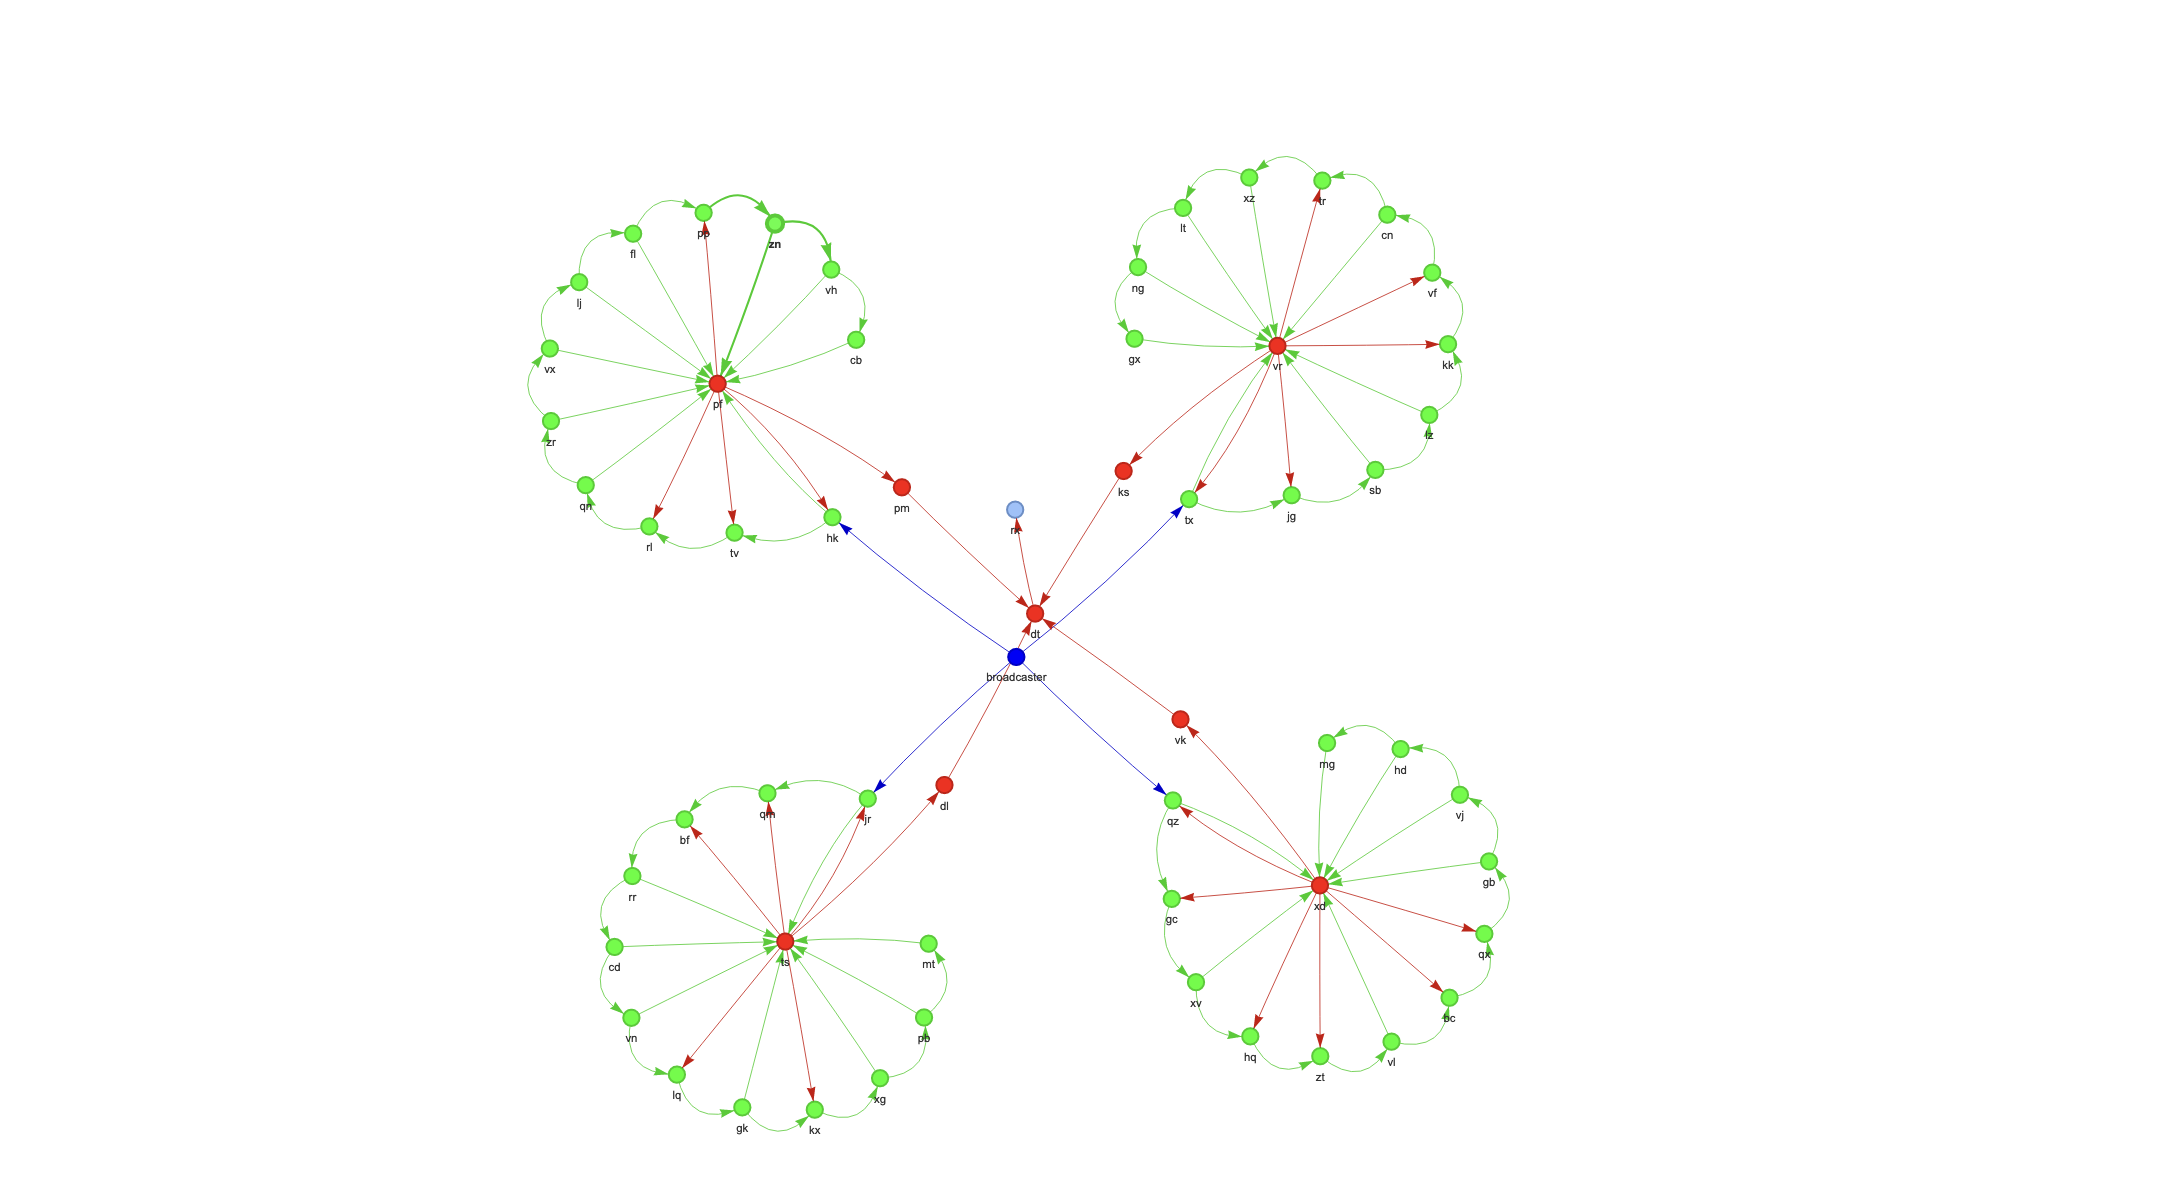

which zoomed in looks like
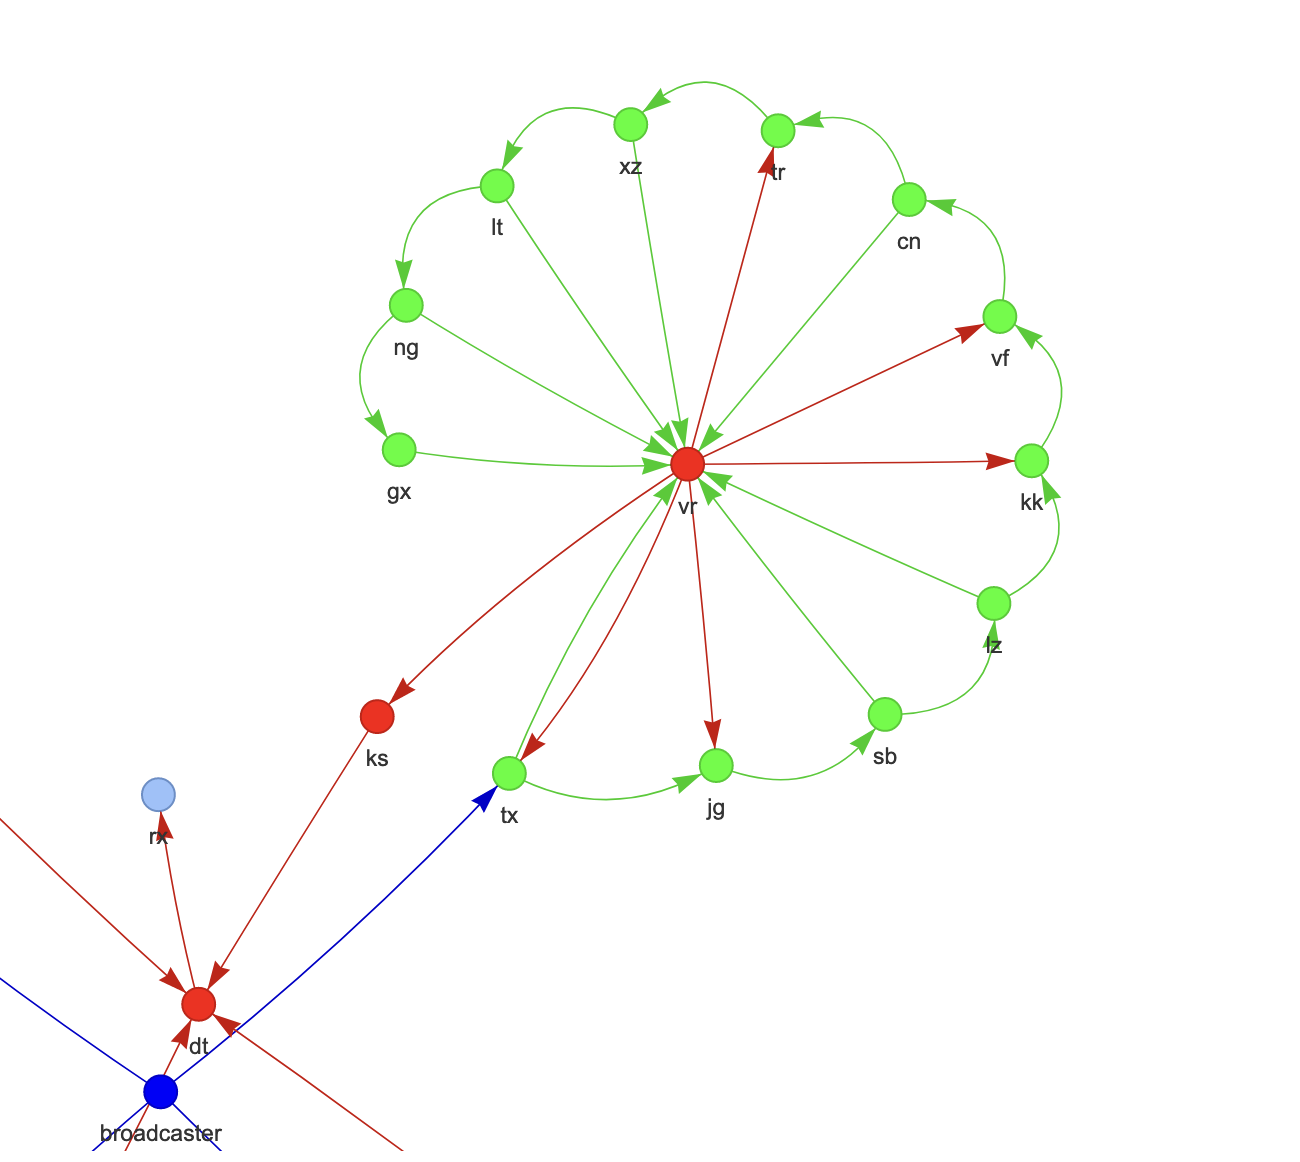

We want to know when `dt` receives a high from `ks`, which means `vr` sends a low pulse, which will happen when all its input nodes last sent a high.

When the button is pressed the broadcaster sends a low pulse to `tx`, which switches on and sends a high pulse to `vr` and `jg`. `vr` sends a high pulse to its connected nodes. These are ignored. 

On the second button press the broadcaster sends a low pulse to `tx`, which switches off and sends a low pulse to `vr` and `jg`. `jg` switches on and sends a high pulse to `sb`, which is ignored.

`tx` is off, `jg` is on.

Third time round `tx` is switched on and sends a high pulse to `jg`, which is ignored.

`tx` is on, `jg` is on.

Fourth time round `tx` is switched off and sends a low pulse to `jg`, which switches off and sends a low pulse to `sb`, which switches on.

`tx` is off, `jg` is off, `sb` is on.

5: on, off, on respectively.

6: off, on, on.

7: on, off, off, on.


In [35]:
def push_button(modules, connections):
    q = deque([("button", "broadcaster", Pulse.LOW)])

    while q:
        source, destination, pulse = q.popleft()
        found = False
        if destination in modules:
            for p in modules[destination].receive(pulse, source):
                for c in connections[destination]:
                    q.append((destination, c, p))

    return modules

modules, connections = parse_data(inp)
for i in range(1, 100):
    modules = push_button(modules, connections)
    print(i)
    print("".join(['X' if modules[m].on else 'O' for m in ["tx", "jg", "sb", "lz", "kk", "vf", "cn", "tr", "xz", "lt", "ng", "gx"]]))
    print("".join([
        'X' if modules['vr'].received[m] == Pulse.HIGH else 'O' 
        for m in ["tx", "jg", "sb", "lz", "kk", "vf", "cn", "tr", "xz", "lt", "ng", "gx"]
    ]))

1
XOOOOOOOOOOO
XOOOOOOOOOOO
2
OXOOOOOOOOOO
OOOOOOOOOOOO
3
XXOOOOOOOOOO
XOOOOOOOOOOO
4
OOXOOOOOOOOO
OOXOOOOOOOOO
5
XOXOOOOOOOOO
XOXOOOOOOOOO
6
OXXOOOOOOOOO
OOXOOOOOOOOO
7
XXXOOOOOOOOO
XOXOOOOOOOOO
8
OOOXOOOOOOOO
OOOXOOOOOOOO
9
XOOXOOOOOOOO
XOOXOOOOOOOO
10
OXOXOOOOOOOO
OOOXOOOOOOOO
11
XXOXOOOOOOOO
XOOXOOOOOOOO
12
OOXXOOOOOOOO
OOXXOOOOOOOO
13
XOXXOOOOOOOO
XOXXOOOOOOOO
14
OXXXOOOOOOOO
OOXXOOOOOOOO
15
XXXXOOOOOOOO
XOXXOOOOOOOO
16
OOOOXOOOOOOO
OOOOOOOOOOOO
17
XOOOXOOOOOOO
XOOOOOOOOOOO
18
OXOOXOOOOOOO
OOOOOOOOOOOO
19
XXOOXOOOOOOO
XOOOOOOOOOOO
20
OOXOXOOOOOOO
OOXOOOOOOOOO
21
XOXOXOOOOOOO
XOXOOOOOOOOO
22
OXXOXOOOOOOO
OOXOOOOOOOOO
23
XXXOXOOOOOOO
XOXOOOOOOOOO
24
OOOXXOOOOOOO
OOOXOOOOOOOO
25
XOOXXOOOOOOO
XOOXOOOOOOOO
26
OXOXXOOOOOOO
OOOXOOOOOOOO
27
XXOXXOOOOOOO
XOOXOOOOOOOO
28
OOXXXOOOOOOO
OOXXOOOOOOOO
29
XOXXXOOOOOOO
XOXXOOOOOOOO
30
OXXXXOOOOOOO
OOXXOOOOOOOO
31
XXXXXOOOOOOO
XOXXOOOOOOOO
32
OOOOOXOOOOOO
OOOOOOOOOOOO
33
XOOOOXOOOOOO
XOOOOOOOOOOO
34
OXOOOXOOOOOO
OOOOOOOOOOOO
35
XXOOOXOOOOOO
XOOOOOO

So the sequence is step 1, 3, 7, 15, 31, 63 for the first 1, 2, 3, 4, 5, 6 flipflops to be on.

In [33]:
def f(n):
    return 1 if n==1 else f(n-1) * 2 + 1

f(12)

4095